In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, roc_curve, classification_report

# 이진 분류 모델의 성능지표
def get_eval_score(test_y, pred, pred_proba_c1= None):
    
    # 혼동행렬(오차행렬)
    confusion = confusion_matrix(test_y, pred)
    # 정밀도(precision)
    precision = precision_score(test_y, pred)
    # 정확도(accuracy_score)
    accuracy = accuracy_score(test_y, pred)
    # 재현율(recall)
    recall = recall_score(test_y, pred)
    # F1 score
    f1 = f1_score(test_y, pred)
    # G-measure -> 정밀도와 재현율의 기하평균 -> np.sqrt(recall_socre*precision_score)
    g = np.sqrt(recall_score(test_y, pred)*precision_score(test_y, pred))

    print(f'confusion matrix:\n{confusion}\n')
    print(f'accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}',end=' ')
    print(f'F1: {f1:.4f}, G: {g:.4f}')
    if pred_proba_c1 is not None:
        auc = roc_auc_score(test_y, pred_proba_c1)
        print(f'auc: {auc:.4f}')

def get_eval_score2(test_y, pred, pred_proba = None):
    
    # 혼동행렬(오차행렬)
    confusion = confusion_matrix(test_y, pred)
    # 정밀도(precision)
    precision = precision_score(test_y, pred, average='macro')
    # 정확도(accuracy_score)
    accuracy = accuracy_score(test_y, pred)
    # 재현율(recall)
    recall = recall_score(test_y, pred, average='macro')
    # F1 score
    f1 = f1_score(test_y, pred, average='macro')
    # G-measure -> 정밀도와 재현율의 기하평균 -> np.sqrt(recall_socre*precision_score)
    g = np.sqrt(recall * precision)

    print(f'confusion matrix:\n{confusion}\n')
    print(f'accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}',end=' ')
    print(f'F1: {f1:.4f}, G: {g:.4f}')
    if pred_proba is not None:
        auc = roc_auc_score(test_y, pred_proba, average='macro', multi_class='ovo')
        print(f'auc: {auc:.4f}')
    print()

In [3]:
# 이진 분류
# 결측치 처리
def fill_na(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    return df

# 레이블 인코딩
def encode_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    for ftr in ['Sex','Cabin','Embarked']: 
        encoder = LabelEncoder()
        encoder.fit(df[ftr])
        df[ftr] = encoder.transform(df[ftr])
    return df

# 원핫인코딩
def encode_features2(df):
    df['Cabin'] = df['Cabin'].str[:1]
    ftrs = ['Sex','Cabin','Embarked']
    dummy = pd.get_dummies(df[ftrs], dtype='int')
    df.drop(ftrs, axis=1,inplace=True)
    df = pd.concat([df, dummy], axis=1)
    return df
    
# 불필요 열 삭제
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 전처리 함수 / 라벨인코딩 적용
def preprocessing_features(df):
    df = fill_na(df)
    df = drop_features(df)
    df = encode_features(df)
    return df

# 전처리 함수 / 원핫인코딩 적용
def preprocessing_features2(df):
    df = fill_na(df)
    df = drop_features(df)
    df = encode_features2(df)
    return df

In [4]:
def plot_importance_top(clf, feature_names,top_n=None):
    importances = pd.Series(clf.feature_importances_, index = feature_names)
    sort_ = importances.sort_values(ascending= False)

    if top_n:
        top_ftr = sort_[:top_n]
        top = 'Top' + str(top_n)
    else:
        top_ftr = sort_
        top = 'All'

    sns.barplot(x=top_ftr, y= top_ftr.index)
    plt.title('Feature Importances')
    plt.show()

### 연습문제. 랜덤포레스트

타이타닉 데이터에 대하여 

1. 랜덤포레스트 모델로 학습/예측/성능제시/피처중요도 시각화하시오.

- n_estimators = 100

In [5]:
# 데이터 로딩 및 전처리, 분리
titanic = pd.read_csv('data/titanic/train.csv')
titanic_cl= preprocessing_features2(titanic)

x = titanic_cl.drop('Survived', axis=1)
y = titanic_cl.Survived

rf_clf = RandomForestClassifier(n_estimators=100)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=156)

In [6]:
rf_clf.fit(train_x, train_y)
pred = rf_clf.predict(test_x)
pred_proba = rf_clf.predict_proba(test_x)[:,1]
get_eval_score(test_y, pred, pred_proba)

confusion matrix:
[[93 14]
 [18 54]]

accuracy: 0.8212, precision: 0.7941, recall: 0.7500 F1: 0.7714, G: 0.7717
auc: 0.8836


In [17]:
print(classification_report(test_y, pred, target_names = ['사망', '생존'], digits=4))

              precision    recall  f1-score   support

          사망     0.8378    0.8692    0.8532       107
          생존     0.7941    0.7500    0.7714        72

    accuracy                         0.8212       179
   macro avg     0.8160    0.8096    0.8123       179
weighted avg     0.8203    0.8212    0.8203       179



In [8]:
rf_clf.feature_importances_

array([6.54355005e-02, 2.42426694e-01, 4.69677975e-02, 3.98889666e-02,
       2.23185410e-01, 1.22966974e-01, 1.46140552e-01, 3.77568496e-03,
       6.85865169e-03, 7.11911982e-03, 7.20667513e-03, 1.02277159e-02,
       3.08006301e-03, 1.53140093e-03, 3.67949174e-02, 6.17093080e-04,
       1.36950921e-02, 6.60645105e-05, 6.03852283e-03, 1.59771043e-02])

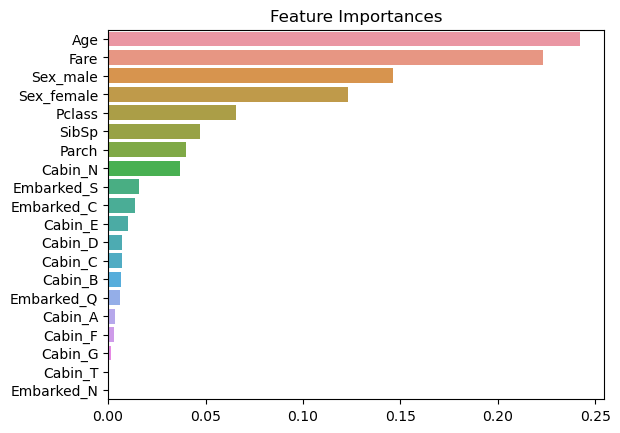

In [16]:
plot_importance_top(rf_clf, train_x.columns)

2. 하이퍼파라미터를 튜닝하여 최적의 모델을 찾아 예측 성능을 제시하고, 피처중요도도 시각화하시오.

```python
params = {'n_estimators':[100, 200],
          'max_depth':[8, 16, 24],
          'min_samples_split':[2, 8, 16],
          'min_samples_leaf':[1, 6, 12]
         }
```

In [10]:
params = {'n_estimators':[100, 200],'max_depth':[8, 16, 24],
          'min_samples_split':[2, 8, 16], 'min_samples_leaf':[1, 6, 12]}
grid = GridSearchCV(rf_clf, param_grid = params, cv=3)
grid.fit(train_x, train_y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 16, 24],
                         'min_samples_leaf': [1, 6, 12],
                         'min_samples_split': [2, 8, 16],
                         'n_estimators': [100, 200]})

In [11]:
print(f'{rf_clf.__class__.__name__}')
print(f'최적의 하이퍼파라미터: {grid.best_params_}')
print(f'최고의 예측 정확도: {grid.best_score_:.4f}')
best_clf = grid.best_estimator_
print(f'{best_clf}')

RandomForestClassifier
최적의 하이퍼파라미터: {'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 100}
최고의 예측 정확도: 0.8174
RandomForestClassifier(max_depth=24, min_samples_split=16)


In [12]:
# 최적의 하이퍼파라미터로 튜닝 / 학습 -> 성능
rf_clf_best = RandomForestClassifier(max_depth = 16, min_samples_leaf=1, 
                                min_samples_split= 16, n_estimators= 200, random_state=0)
rf_clf_best.fit(train_x, train_y)
pred_ = rf_clf_best.predict(test_x)
pred_proba_ = rf_clf_best.predict_proba(test_x)[:,1]
get_eval_score(test_y, pred_, pred_proba_)

confusion matrix:
[[97 10]
 [21 51]]

accuracy: 0.8268, precision: 0.8361, recall: 0.7083 F1: 0.7669, G: 0.7696
auc: 0.8819


In [13]:
print(classification_report(test_y, pred_, target_names = ['사망', '생존'], digits=4))

              precision    recall  f1-score   support

          사망     0.8220    0.9065    0.8622       107
          생존     0.8361    0.7083    0.7669        72

    accuracy                         0.8268       179
   macro avg     0.8290    0.8074    0.8146       179
weighted avg     0.8277    0.8268    0.8239       179



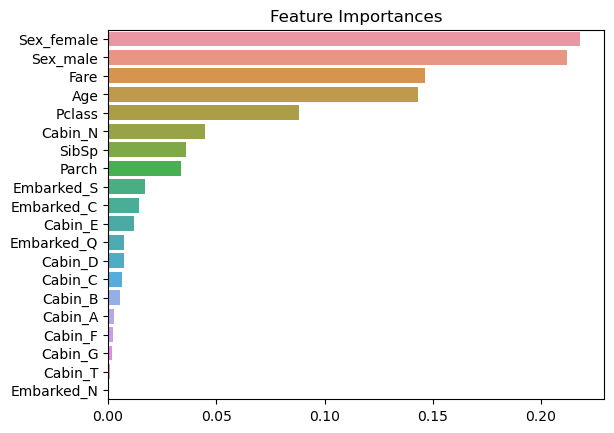

In [18]:
# 피처 중요도 시각화
plot_importance_top(rf_clf_best, train_x.columns)